# Prediction Evaluation

This notebook evaluates top 1, 3, 5 and 10 predictions for models trained on datasets with no augmentation, 4x augmentation, 16x augmentation and 40x augmentation.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import math, matplotlib.pyplot as plt, numpy as np, pandas as pd, random
from pathlib import Path
from rdkit.Chem import AllChem
from rdkit import Chem
from rdkit.Chem import Draw

In [3]:
output_files= {
    'no_aug' :    ['retro_no_aug_1.txt',
                   'retro_no_aug_3.txt',
                   'retro_no_aug_5.txt',
                   'retro_no_aug_10.txt'],
    
    'small_aug' : ['retro_small_aug_1.txt',
                   'retro_small_aug_3.txt',
                   'retro_small_aug_5.txt',
                   'retro_small_aug_10.txt'],
    
    'medium_aug' : ['retro_med_aug_1.txt',
                    'retro_med_aug_3.txt',
                    'retro_med_aug_5.txt',
                    'retro_med_aug_10.txt',],
    
    'large_aug' : ['retro_large_aug_1.txt',
                   'retro_large_aug_3.txt',
                   'retro_large_aug_5.txt',
                   'retro_large_aug_10.txt',]
}

In [4]:
path = Path('G:/OpenNMT-py')
prediction_path = path/'experiments/retro_aug_experiments/'

In [5]:
# Load ground truth data
df_trains = pd.read_csv(path/'data/retrosynthesis/test_sources.txt', sep='\n', header=None, names=['Sources'])
df_traint = pd.read_csv(path/'data/retrosynthesis/test_targets.txt', sep='\n', header=None, names=['Targets'])

df = pd.concat([df_trains, df_traint], axis=1)

## SMILES Canonicalization

SMILES strings have many equivalent representations. When we evaluate accuracy, we want to make sure that a correct prediction is counted as correct regardless of the orientation of the SMILES string.

To do this, we canonicalize the SMILES predictions using RDKit

In [6]:
def canonicalize_smiles(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        return Chem.MolToSmiles(mol, isomericSmiles=True)
    else:
        return ''

In [7]:
def canonicalize_prediction(smiles):
    smiles = ''.join(smiles.split(' '))
    return canonicalize_smiles(smiles)

In [8]:
def topk_correct(row, cols):
    # for top K predictions, we look for any one prediction being correct
    targ = row['Targets']
    
    preds = [row[i] for i in cols]
    
    return any([targ == i for i in preds])

In [9]:
def unique_preds(row, cols):
    
    preds = [row[i] for i in cols]
    
    unique_smis = list(set(preds))
    
    return len(unique_smis)

In [10]:
def process_topk(filename, k=5):
    
    # load predictions
    # reshape dataframe for top K value
    df_preds = pd.read_csv(filename, sep='\n', header=None, names=['Preds'])
    cols = ['P' + str(i+1) for i in range(k)]
    
    df_preds = pd.DataFrame(df_preds.Preds.values.reshape(df_preds.shape[0]//k, k))
    df_preds.columns = cols
    
    # concat with ground truth data
    df_preds = pd.concat([df, df_preds], axis=1)
    
    # unique predicted strings
    df_preds['str_unique'] = df_preds.apply(lambda row: unique_preds(row, cols), axis=1)
    
    # Canonicalize targets
    df_preds.Targets = df_preds.Targets.map(lambda x: canonicalize_prediction(x))
    
    # Canonicalize predictions
    for c in cols:
        df_preds[c] = df_preds[c].map(lambda x: canonicalize_prediction(x))
        
    # Unique predictions after canonicalization
    df_preds['chem_unique'] = df_preds.apply(lambda row: unique_preds(row, cols), axis=1)
        
    # Correct prediction at top K level
    df_preds['Correct'] = df_preds.apply(lambda row: topk_correct(row, cols), axis=1)
    
    return df_preds

In [11]:
class ProcessPreds():
    # class to process all predictions in a given group
    def __init__(self, path, filenames, ks, title):
        self.filenames = [path/file for file in filenames]
        self.ks = ks
        
        self.dfs = [process_topk(f, k) for f,k in zip(self.filenames, ks)]
        self.title = title
        
    def accuracy_stats(self):
        return [d.Correct.mean() for d in self.dfs]
    
    def unique_prediction_stats(self):
        return [d.chem_unique.mean() for d in self.dfs]
        
    def print_results(self):
        print(self.title)
        print(f'Top-1 Accuracy: {self.dfs[0].Correct.mean():.3f}')
        print(f'Top-3 Accuracy: {self.dfs[1].Correct.mean():.3f}')
        print(f'Top-5 Accuracy: {self.dfs[2].Correct.mean():.3f}')
        print(f'Top-10 Accuracy: {self.dfs[3].Correct.mean():.3f}')
        
        print('\n')
        print(f'Top-3 Unique Predictions: {self.dfs[1].chem_unique.mean():.3f}')
        print(f'Top-5 Unique Predictions: {self.dfs[2].chem_unique.mean():.3f}')
        print(f'Top-10 Unique Predictions: {self.dfs[3].chem_unique.mean():.3f}')

In [12]:
class ProcessAllPreds():
    # designed to process all 16 prediction files
    def __init__(self, path, outputs, ks, titles):
        
        self.preds = [ProcessPreds(path, outputs[key], ks, title) 
                          for key, title in zip(outputs.keys(), titles)]
        self.create_stat_dataframes()
        
    def get_accuracy(self):
        self.accs = [p.accuracy_stats() for p in self.preds]
        
    def get_unique(self):
        self.unique_preds = [p.unique_prediction_stats() for p in self.preds]
        
    def create_stat_dataframes(self):
        # gets accuracy values and number of chemically unique predictions for each group in titles
        self.get_accuracy()
        self.get_unique()
        
        self.acc_df = pd.DataFrame(self.accs, columns=['Top-1 Accuracy', 'Top-3 Accuracy', 
                               'Top-5 Accuracy', 'Top-10 Accuracy'],
                     index=titles)
        
        self.unique_df = pd.DataFrame(self.unique_preds, columns=['Top-1 Accuracy', 'Top-3 Accuracy', 
                               'Top-5 Accuracy', 'Top-10 Accuracy'],
                     index=titles)
        
    def plot_accuracy(self):
        
        fig, axes = plt.subplots(figsize=(11,8))
        plt.title('Accuracy', fontsize=16)
        idx = self.acc_df.index
        axes.plot(idx, self.acc_df['Top-1 Accuracy'], label='Top-1')
        axes.plot(idx, self.acc_df['Top-3 Accuracy'], label='Top-3')
        axes.plot(idx, self.acc_df['Top-5 Accuracy'], label='Top-5')
        axes.plot(idx, self.acc_df['Top-10 Accuracy'], label='Top-10')
        axes.legend()
        axes.tick_params(axis='both', which='major', labelsize=14)
        axes.set_xlabel('Augmentation Condition', fontsize=14, labelpad=20)
        axes.set_ylabel('Accuracy', fontsize=14)
        
    def plot_unique(self):
        
        fig, axes = plt.subplots(figsize=(11,8))
        plt.title('Chemically Unique Predictions', fontsize=16)
        idx = self.unique_df.index
        axes.plot(idx, self.unique_df['Top-1 Accuracy'], label='Top-1')
        axes.plot(idx, self.unique_df['Top-3 Accuracy'], label='Top-3')
        axes.plot(idx, self.unique_df['Top-5 Accuracy'], label='Top-5')
        axes.plot(idx, self.unique_df['Top-10 Accuracy'], label='Top-10')
        axes.legend()
        axes.tick_params(axis='both', which='major', labelsize=14)
        axes.set_xlabel('Augmentation Condition', fontsize=14, labelpad=20)
        axes.set_ylabel('Chemically Unique Predictions', fontsize=14)

In [13]:
ks = [1,3,5,10]
titles = ['No Augmentation', '4x Augmentation', 
          '16x Augmentation', '40x Augmentation']

In [14]:
predictions = ProcessAllPreds(prediction_path, output_files, ks, titles)

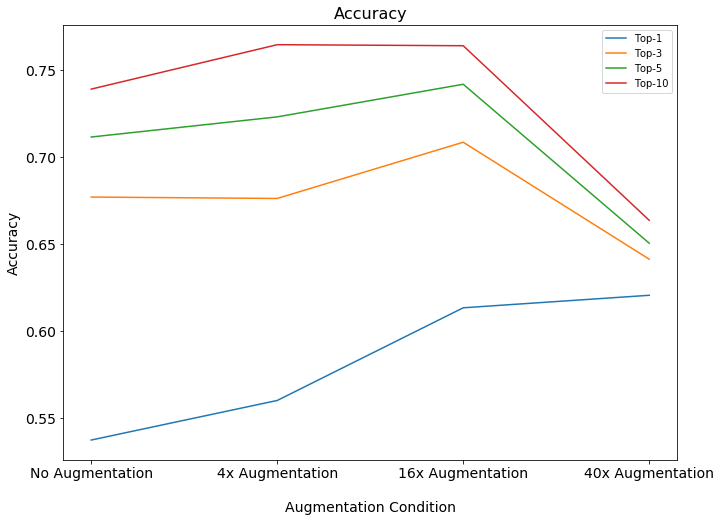

In [15]:
predictions.plot_accuracy()

In [17]:
predictions.acc_df

,Top-1 Accuracy,Top-3 Accuracy,Top-5 Accuracy,Top-10 Accuracy
No Augmentation,0.537170,0.677058,0.711631,0.739209
4x Augmentation,0.559952,0.676259,0.723221,0.764788
16x Augmentation,0.613309,0.708633,0.742006,0.764189
40x Augmentation,0.620504,0.641287,0.650480,0.663669


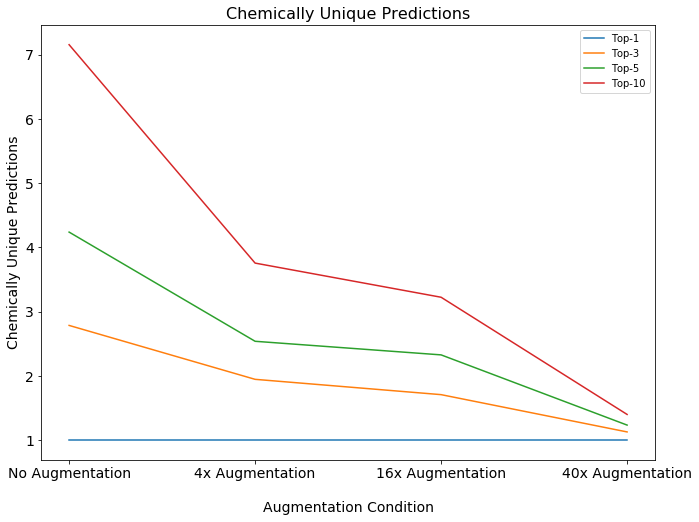

In [16]:
predictions.plot_unique()

In [18]:
predictions.unique_df

,Top-1 Accuracy,Top-3 Accuracy,Top-5 Accuracy,Top-10 Accuracy
No Augmentation,1.0,2.784373,4.237410,7.155076
4x Augmentation,1.0,1.945044,2.537370,3.754796
16x Augmentation,1.0,1.706635,2.325739,3.223022
40x Augmentation,1.0,1.126099,1.232614,1.398481
